##Проект по анализу данных

Реализуем проект, в котором будем анализировать несколько датасетов (источники помечены цифрами):  

1_alcohol.csv - уровень употребления алкоголя (по странам)  
1_cancer.csv - шанс заболеть раком (по странам)  
1_life_expectancy.csv - ожидаемый срок жизни (по странам)  
1_pollution.csv - уровень смертности от загрязнения (по странам)  
2_emissions.csv - уровень выбросов CO2 в атмосферу (по странам)  
3_suicide.csv - количество суицидов на 10000 человек (по странам)

В данной работе я хочу рассмотреть влияние уровня смертности от загрязнения окружающей среды на все остальные признаки, особенно на продолжительность жизни и возможность умереть от заболевания раком. Интересно также увидеть коррелирует ли уровень употребления алкоголя со смертностью от рака или ожидаемым сроком жизни. Возможно нам удастся выявить какие-либо другие закономерности.

## Предобработка данных

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pylab
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import abc

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Считываем таблицы

alcohol = pd.read_csv('1_alcohol.csv')
cancer = pd.read_csv('1_cancer.csv')
life_expectancy = pd.read_csv('1_life_expectancy.csv')
pollution = pd.read_csv('1_pollution.csv')
emissions = pd.read_csv('2_emissions.csv')
suicide = pd.read_csv('3_suicide.csv')


In [3]:
# Оставляем в таблице alcohol статистику для обоих полов и берем среднее значение за все года для каждой страны

alcohol = alcohol.loc[alcohol['Dim1'] == 'Both sexes']
alcohol = alcohol.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
alcohol.rename(columns={'First Tooltip': 'Alcohol consumption', 'Location': 'Country'}, inplace=True)
alcohol = alcohol.drop('Indicator', axis=1)
alcohol
# По итогу оставляем просто таблицу страна - уровень употребления алкоголя

,Country,Alcohol consumption
0,Afghanistan,0.2100
1,Albania,7.1640
2,Algeria,0.7840
3,Andorra,11.7940
4,Angola,6.1420
...,...,...
183,Venezuela (Bolivarian Republic of),7.6400
184,Viet Nam,5.2520
185,Yemen,0.2832
186,Zambia,5.3620


In [4]:
# Оставляем в таблице cancer статистику для обоих полов и берем среднее значение за все года для каждой страны (аналогично)
cancer = cancer.loc[cancer['Dim1'] == 'Both sexes']
cancer = cancer.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
cancer.rename(columns={'First Tooltip': 'Probability (%) of cancer death >30 <70 years', 'Location': 'Country'}, inplace=True)
cancer = cancer.drop('Indicator', axis=1)
cancer
# По итогу оставляем просто таблицу страна - шанс умереть от рака

,Country,Probability (%) of cancer death >30 <70 years
0,Afghanistan,31.96
1,Albania,18.24
2,Algeria,16.54
3,Angola,19.36
4,Antigua and Barbuda,22.36
...,...,...
179,Venezuela (Bolivarian Republic of),19.14
180,Viet Nam,17.88
181,Yemen,31.78
182,Zambia,20.02


In [5]:
# Аналогично для life_expectancy
life_expectancy = life_expectancy.loc[life_expectancy['Dim1'] == 'Both sexes']
life_expectancy = life_expectancy.groupby(['Location', 'Indicator'])['First Tooltip'].mean().reset_index()
life_expectancy.rename(columns={'First Tooltip': 'Life expectancy', 'Location': 'Country'}, inplace=True)
life_expectancy = life_expectancy.drop('Indicator', axis=1)
life_expectancy
# По итогу оставляем просто таблицу страна - ожидаемый срок жизни

,Country,Life expectancy
0,Afghanistan,59.9475
1,Albania,76.4100
2,Algeria,75.4325
3,Angola,58.0375
4,Antigua and Barbuda,75.7750
...,...,...
179,Venezuela (Bolivarian Republic of),74.3725
180,Viet Nam,72.7675
181,Yemen,66.1225
182,Zambia,56.0200


In [6]:
# В pollution, помимо предыдущих преобразований,
# мы еще оставляем только один индикатор (Смертность на 100 000, без нормализации по возрасту)
# и оставляем только общую статистику смертей, без конкретных болезней
pollution = pollution.loc[(pollution['Dim1'] == 'Both sexes') & (pollution['Dim2'] == 'Total')]
pollution = pollution.loc[pollution['Indicator'] == 'Ambient and household air pollution attributable death rate (per 100 000 population)']
pollution['First Tooltip'] = pollution['First Tooltip'].apply(lambda x: float(str(x).split(' [')[0]))
pollution = pollution.drop('Dim2', axis=1).drop('Dim1', axis=1).drop('Period', axis=1)
pollution = pollution.drop('Indicator', axis=1)
pollution = pollution.reset_index().drop('index', axis=1)
pollution.rename(columns={'Location': 'Country', 'First Tooltip': 'Pollution Death rate'}, inplace=True)
pollution
# По итогу оставляем просто таблицу страна - уровень смертности от загрязнения на 100 000 человек

,Country,Pollution Death rate
0,Afghanistan,95.12
1,Albania,104.70
2,Algeria,40.33
3,Angola,67.25
4,Antigua and Barbuda,28.29
...,...,...
178,Venezuela (Bolivarian Republic of),28.95
179,Viet Nam,65.14
180,Yemen,89.75
181,Zambia,63.39


In [7]:
# В emissions просто убираем все, кроме нужного
emissions = emissions.drop(emissions.columns.difference(['Country','Unnamed: 7']), axis=1)
emissions = emissions.drop([0, 1, 2, 3])
emissions.rename(columns={'Unnamed: 7':'Fossil CO2 emissions per capita(t CO2/cap/yr)'}, inplace=True)
emissions['Fossil CO2 emissions per capita(t CO2/cap/yr)'] = emissions['Fossil CO2 emissions per capita(t CO2/cap/yr)'].astype(float)
emissions

,Country,Fossil CO2 emissions per capita(t CO2/cap/yr)
4,Afghanistan,0.3
5,Albania,1.7
6,Algeria,3.9
7,Angola,1.0
8,Anguilla,1.9
...,...,...
208,Vietnam,2.3
209,Western Sahara,0.5
210,Yemen,0.4
211,Zambia,0.3


In [8]:
# Аналогично в suicide, только тут мы берем среднее для нескольких лет
suicide['suicide_mean'] = suicide.iloc[:, 1:].mean(axis=1)
suicide = suicide.drop(suicide.columns.difference(['Country','suicide_mean']), axis=1)
suicide['Country'].replace('Afghanistan *', 'Afghanistan', inplace=True)
suicide

,Country,suicide_mean
0,Afghanistan,6.850
1,Albania,5.680
2,Algeria,3.340
3,Angola,14.855
4,Antigua and Barbuda,0.650
...,...,...
178,Venezuela,3.845
179,Vietnam,7.285
180,Yemen,7.550
181,Zambia,19.465


In [9]:
# И мерджим все в одну таблицу
final = pd.merge(alcohol, cancer, on='Country', how='inner')
final = pd.merge(final, life_expectancy, on='Country', how='inner')
final = pd.merge(final, pollution, on='Country', how='inner')
final = pd.merge(final, emissions, on='Country', how='inner')
final = pd.merge(final, suicide, on='Country', how='inner')
final

,Country,Alcohol consumption,Probability (%) of cancer death >30 <70 years,Life expectancy,Pollution Death rate,Fossil CO2 emissions per capita(t CO2/cap/yr),suicide_mean
0,Afghanistan,0.2100,31.96,59.9475,95.12,0.3,6.850
1,Albania,7.1640,18.24,76.4100,104.70,1.7,5.680
2,Algeria,0.7840,16.54,75.4325,40.33,3.9,3.340
3,Angola,6.1420,19.36,58.0375,67.25,1.0,14.855
4,Antigua and Barbuda,5.6740,22.36,75.7750,28.29,6.1,0.650
...,...,...,...,...,...,...,...
122,Uzbekistan,3.6040,27.00,69.9800,54.10,3.0,9.475
123,Vanuatu,1.6920,25.08,64.5925,75.76,0.3,21.855
124,Yemen,0.2832,31.78,66.1225,89.75,0.4,7.550
125,Zambia,5.3620,20.02,56.0200,63.39,0.3,19.465


Итого, объединив все данные в одну таблицу мы будем смотреть на следующие факторы по странам:


*   Alcohol consumption - уровень употребления алкоголя (в литрах в год на душу населения)                         
*   Probability (%) of cancer death >30 <70 years - шанс умереть от заболевания раком в период с 30 до 70 лет (в процентах)
*   Life expectancy - продолжительность жизни (в годах)                               
*   Pollution Death rate - уровень смертности, обусловленный загрязнением домашнего хозяйства и окружающего воздуха (на 100 000 населения)
*   Fossil CO2 emissions per capita(t CO2/cap/yr) - выбросы СО2 в атмосферу (в год на душу населения)                      
*   suicide_mean - среднее количество успешно совершенных суицидов (на 10 000 населения)



Посмотрим на пропуски и дубли в данных.

In [10]:
print(final.isnull().sum())
print(final[final.duplicated ()].sum())

Country                                          0
Alcohol consumption                              0
Probability (%) of cancer death >30 <70 years    0
Life expectancy                                  0
Pollution Death rate                             0
Fossil CO2 emissions per capita(t CO2/cap/yr)    0
suicide_mean                                     0
dtype: int64
Country                                            0
Alcohol consumption                              0.0
Probability (%) of cancer death >30 <70 years    0.0
Life expectancy                                  0.0
Pollution Death rate                             0.0
Fossil CO2 emissions per capita(t CO2/cap/yr)    0.0
suicide_mean                                     0.0
dtype: object


Пропуски и дубли в данных отсутствуют.

Выведем основные статистики данных: среднее, перцентили (0.25, 0.5, 0.75), минимум, максимум, стандартное отклонение.

In [11]:
final.describe()

,Alcohol consumption,Probability (%) of cancer death >30 <70 years,Life expectancy,Pollution Death rate,Fossil CO2 emissions per capita(t CO2/cap/yr),suicide_mean
count,127.00000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,5.58592,20.709921,69.525335,65.942047,4.333858,11.276654
std,3.90448,5.303268,8.424316,36.871002,5.952460,9.711110
min,0.01900,10.680000,48.405000,12.840000,0.000000,0.650000
25%,2.14300,16.900000,62.521250,37.995000,0.600000,5.500000
50%,5.36200,20.780000,72.010000,57.390000,2.000000,9.475000
75%,8.17400,24.420000,75.990000,87.840000,5.950000,14.630000
max,14.05200,33.480000,81.462500,184.000000,37.100000,77.515000


Посчитаем корреляции всех признаков со всеми другими. Корреляция показывает степень взаимосвязи между двумя переменными. Соответственно, значение -1 указывает на сильную отрицательную взаимосвязь, а значение 1 — на сильную положительную взаимосвязь (поэтому на диагонали стоят единицы).

In [12]:
final.drop('Country', axis=1).corr()

,Alcohol consumption,Probability (%) of cancer death >30 <70 years,Life expectancy,Pollution Death rate,Fossil CO2 emissions per capita(t CO2/cap/yr),suicide_mean
Alcohol consumption,1.000000,-0.280369,0.338516,-0.164466,0.161294,0.147351
Probability (%) of cancer death >30 <70 years,-0.280369,1.000000,-0.569624,0.553942,-0.258801,0.251347
Life expectancy,0.338516,-0.569624,1.000000,-0.620419,0.462521,-0.551290
Pollution Death rate,-0.164466,0.553942,-0.620419,1.000000,-0.426308,0.260172
Fossil CO2 emissions per capita(t CO2/cap/yr),0.161294,-0.258801,0.462521,-0.426308,1.000000,-0.149026
suicide_mean,0.147351,0.251347,-0.551290,0.260172,-0.149026,1.000000


Мы предобработали данные для максимально комфортного их последующего анализа.

## Exploratory Data Analysis

Просто таблица корреляций не очень удобна для анализа. Визуализируем heatmap корреляций. Оставим значения корреляций, которые по модулю не меньше 0.33. Будем считать такие корреляции существенными.

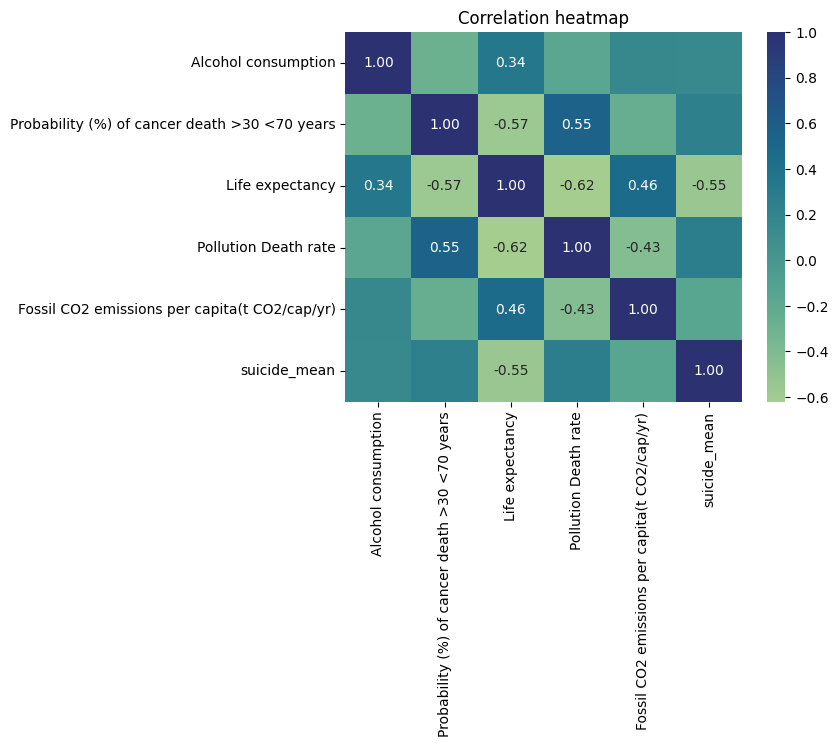

In [13]:
plt.title("Correlation heatmap")

for i in sns.heatmap(final.drop('Country', axis=1).corr(), annot=True, fmt=".2f", cmap="crest").texts:
    if abs(float(i.get_text())) < 0.33:
        i.set_text("")

plt.show()

Как наглядно видно из тепловой карты, самый низкий уровень зависимости от каких-либо других признаков показывает уровень потребления алкоголя в стране.

Вместе с этим, самый высокий уровень корреляции у таких признаков как продолжительность жизни и уровень смертности от загрязнения. Также шанс заболевания раком в стране очень сильно влияет на ожидаемый срок жизни.

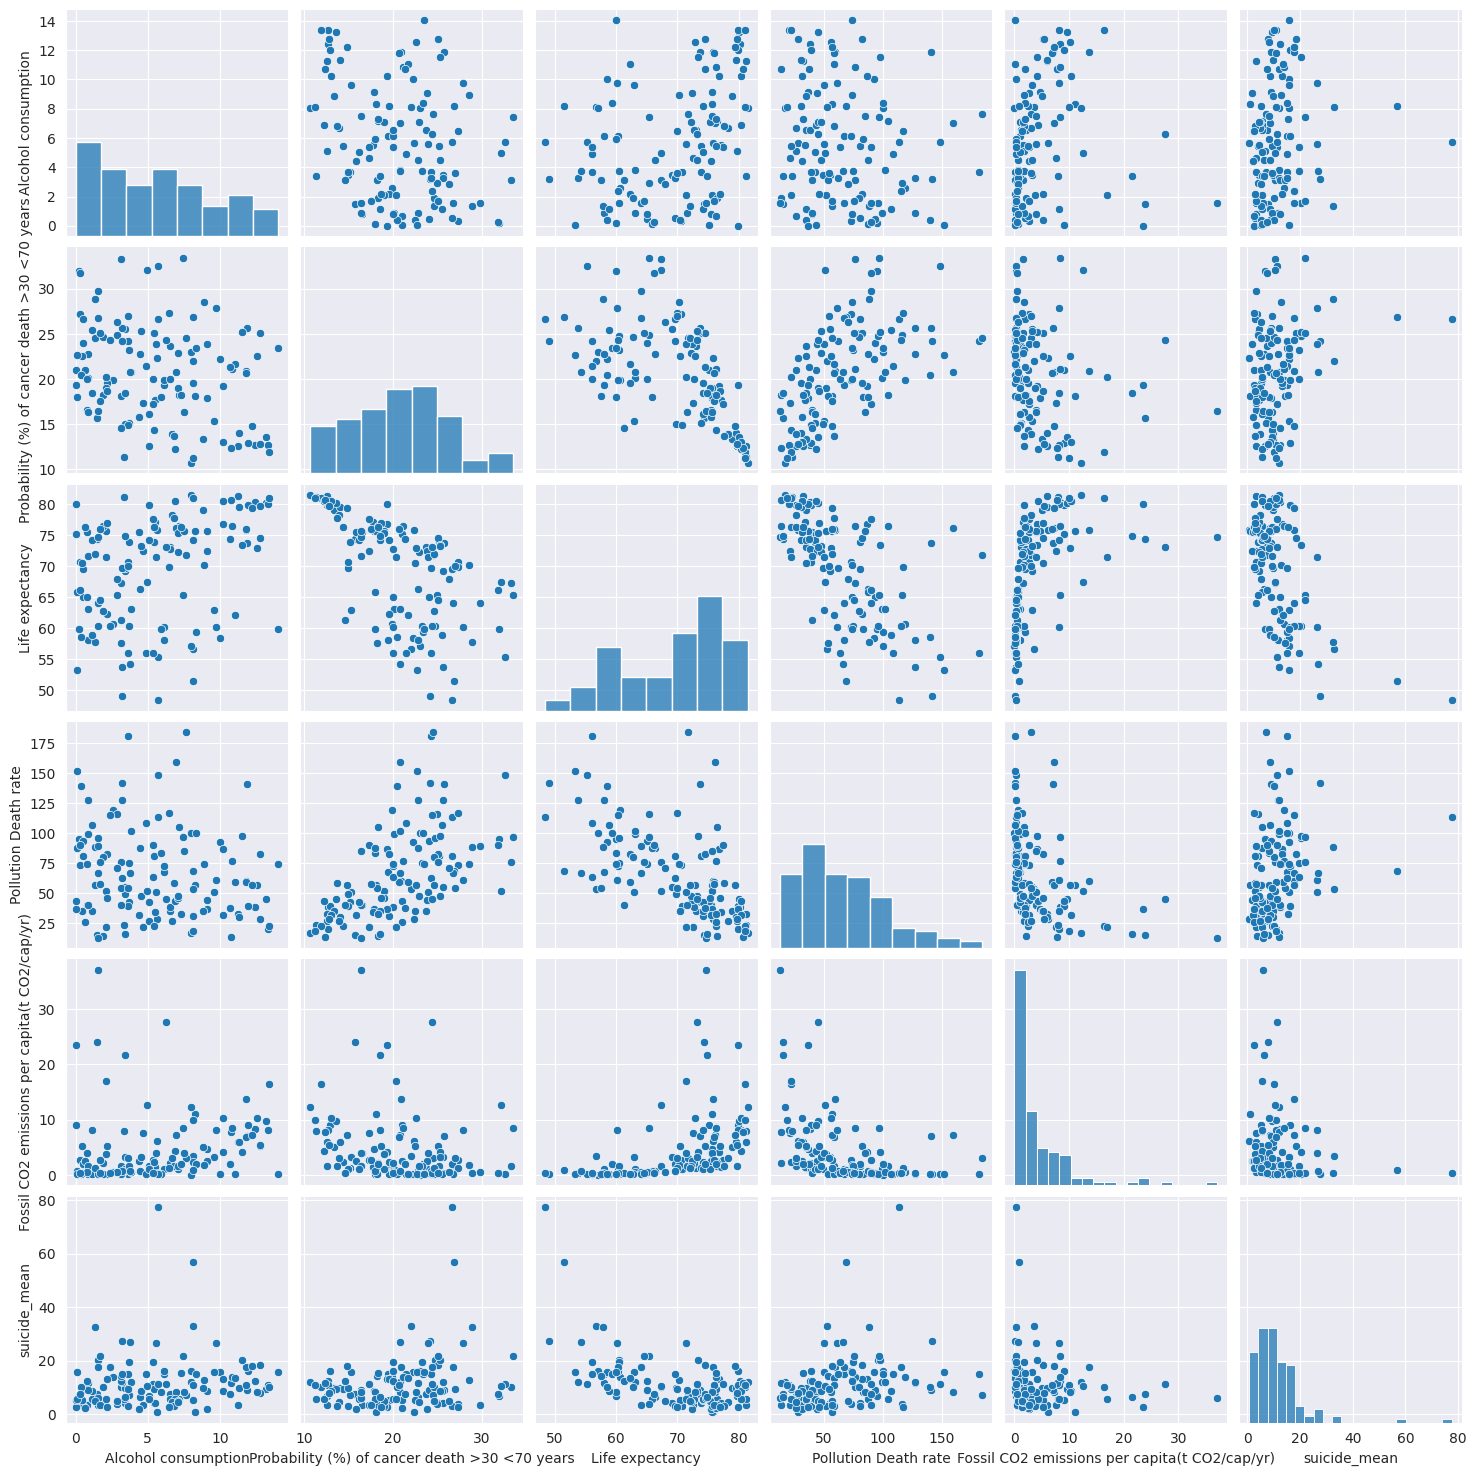

In [14]:
# Теперь посмотрим на корреляции признаков на графиках, возможно сможем визуально выявить некоторые зависимости и выдвинуть гипотезы

sns.set_style("darkgrid")
sns.pairplot(final)

Меня заинтересовал график корреляции количества суицидов на 10 000 человек и шанс смерти от заболевания раком в стране. Можно предположить, что чем выше смертность от рака в стране, тем больше суицидов может происходить. Однако, зависимость выражена слабо и требует проверки.

С помощью визуализации явно видим обратную и прямую зависимости продолжительности жизни и смертности от загрязнений от шанса смерти от рака.
Рассмотрим данную закономерность подробнее. Для этого используем метод Seaborn.jointplot() для построения попарных взаимосвязей в наборе данных.

<Figure size 1400x500 with 0 Axes>

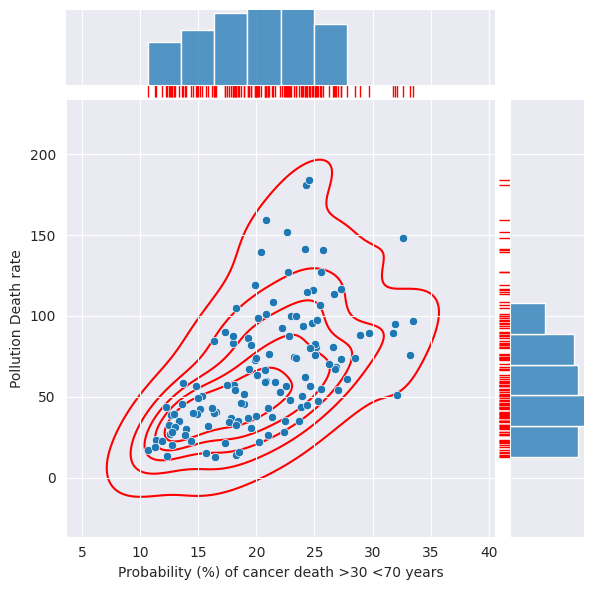

In [15]:
fig = plt.figure(figsize=(14, 5))
fig = sns.jointplot(data=final, x='Probability (%) of cancer death >30 <70 years', y='Pollution Death rate')
fig.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
fig.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)


На объединенном графике хорошо видно динамику поведения переменных и их распределение. Так, можем выдвинуть гипотезу об увеличивающейся возможности смерти от заболевания раком при росте уровня смертности от загрязнений окружающей среды.

In [16]:
res = stats.pearsonr(final['Probability (%) of cancer death >30 <70 years'], final['Pollution Death rate'])
print('Pearson rho: ', res[0])
print('p-value: ', res[1])

Pearson rho:  0.553941860950946
p-value:  1.4235699625985767e-11


Проверили гипотезу о том, что коэффициент корреляции равен 0. Из значения p-value следует, что данная гипотеза отвергнута, зависимость точно есть.

Кроме того, на тепловой карте мы выявили высокий уровень зависимости между числом самоубийц, приходящихся на 10 000 человек, и продолжительностью жизни в стране. Мы хотим сравнить данный показатель и процент смертности в стране от рака (он тоже довольно высок).

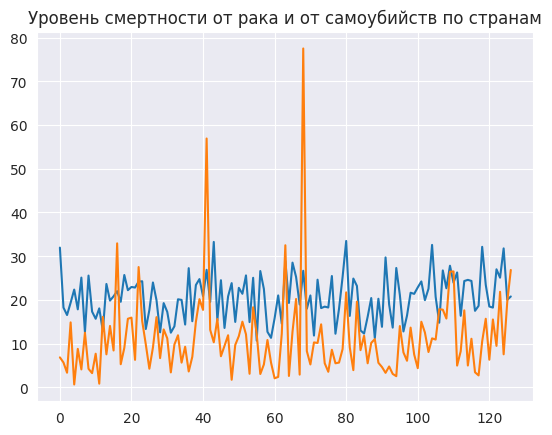

In [17]:
pylab.plot (final['Probability (%) of cancer death >30 <70 years'])
pylab.plot (final['suicide_mean'])
pylab.title ("Уровень смертности от рака и от самоубийств по странам")

# Покажем окно с нарисованным графиком
pylab.show()


Проверяем с помощью критерия Флигнера-Килина гипотезу о равенстве значений дисперсии, поскольку критерий Флигнера-Килина не требует предположений о нормальности сравниваемых выборок и оценивает совокупное распеределение рангов абсолютных разностей.

In [18]:
cancer = final['Probability (%) of cancer death >30 <70 years']
suicide = final['suicide_mean']
res = stats.fligner(cancer, suicide)
print('p-value: ', res[1])

p-value:  0.17879838135908274


Значение p-value высокое, поэтому отвергуть гипотезу о равенстве дисперсий мы не можем. Так, разброс в выборках обоих признаков одинаков.

Добавим новый категориальный признак для сравнения. В случае, если средняя продолжительность жизни менее 65 лет, будем считать такую страну неблагоприятной для жизни, и наоборот.

In [19]:
final['suitable'] = np.where(final['Life expectancy']>=65, 'yes', 'no')
final

,Country,Alcohol consumption,Probability (%) of cancer death >30 <70 years,Life expectancy,Pollution Death rate,Fossil CO2 emissions per capita(t CO2/cap/yr),suicide_mean,suitable
0,Afghanistan,0.2100,31.96,59.9475,95.12,0.3,6.850,no
1,Albania,7.1640,18.24,76.4100,104.70,1.7,5.680,yes
2,Algeria,0.7840,16.54,75.4325,40.33,3.9,3.340,yes
3,Angola,6.1420,19.36,58.0375,67.25,1.0,14.855,no
4,Antigua and Barbuda,5.6740,22.36,75.7750,28.29,6.1,0.650,yes
...,...,...,...,...,...,...,...,...
122,Uzbekistan,3.6040,27.00,69.9800,54.10,3.0,9.475,yes
123,Vanuatu,1.6920,25.08,64.5925,75.76,0.3,21.855,no
124,Yemen,0.2832,31.78,66.1225,89.75,0.4,7.550,yes
125,Zambia,5.3620,20.02,56.0200,63.39,0.3,19.465,no


Выдвинем гипотезу, что количество суицидов в благоприятных для жизни странах не отличается от жизни в неблагоприятных.

Для проверки предположения одинаковости сохраним в отдельные переменные выборки, которые собираемся сравнивать.

In [20]:
x = final[final['suitable'] == 'yes']['suicide_mean']
y = final[final['suitable'] == 'no']['suicide_mean']
x.name, y.name = 'suitable', 'not suitable'

Проверяем нормальность распределений.

In [21]:
def two_histograms(x, y):
  '''
  Функция, которая построит две гистограммы на одной картинке.
  Дополнительно пунктирными линиями указываются средние значения выборок.
  '''
  x.hist(alpha=0.5, weights=[1./len(x)]*len(x))
  y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
  plt.axvline(x.mean(), color='red', linestyle='dashed')
  plt.axvline(y.mean(), color='green', linestyle='dashed')
  plt.legend([x.name, y.name])

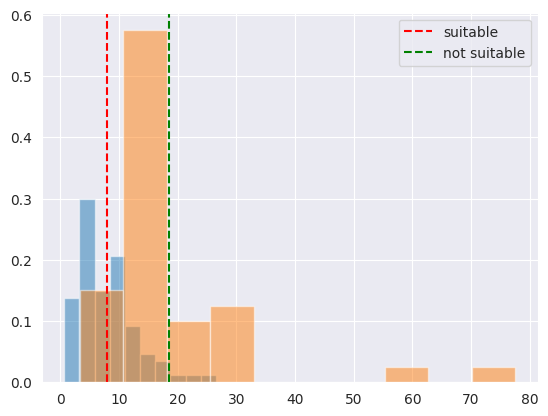

In [22]:
two_histograms(x, y)

В распределении есть очевидные выбросы, которые не дают применить критерий Стюдента. Можно было бы попробовать избавиться от них, но удаление выбросов не сделает данные более нормальными: слишком большие столбики выброса. Критерий Уилкоксона применим только для парных выборок. У нас же в разных выборках находятся разные объекты (страны). Поэтому нам остается критерий Манна-Уитни.

In [23]:
res = stats.mannwhitneyu(x, y)
print('p-value: ', res[1])

p-value:  4.423821171118105e-11


p-value получилось достаточно маленьким, поэтому гипотезу отвергаем.

Вывод: количество суицидов в благоприятных и неблагоприятных странах отличается - разница медиан в выборках не случайна.

##Линейная регрессия

Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Как уже смотрели в предобработке, такие значения в собранном датасете отсутствуют. Поэтому можно переходить непосредственно к построению моделей.

В наших данных есть переменная Life expectancy (продолжительность жизни), которую есть смысл попробовать предсказать на основе ряда факторов, таких как уровень потребления алкоголя, вероятность умереть от рака в возрасте от 30 до 70 лет, уровень смертности, обусловленный загрязнением воздуха, выбросы CO2 на душу населения и среднее количество успешно совершенных суицидов.

Так, мы решим задачу регрессии, то есть задачу прогнозирования непрерывной целевой переменной на основе набора признаков. Мы будем использовать среднюю абсолютную ошибку (MAE) для измерения качества нашей модели.


Аккуратно разобьем выборку на обучающую и тестовую.

In [115]:
X_train = final[['Alcohol consumption', 'Probability (%) of cancer death >30 <70 years', 'Pollution Death rate', 'Fossil CO2 emissions per capita(t CO2/cap/yr)']]
y_train = final['Life expectancy']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=148)

In [116]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Считаем качество модели (коэффициент R^2):

In [117]:
print('R^2: {0}'.format(model.score(X_train, y_train)))

R^2: 0.4553779747525233


0.45 для тех данных, которые у нас есть, - вполне нормальное значение.

In [118]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()), columns=['predict', 'coef'])
coef

,predict,coef
0,intercept,80.548004
1,Alcohol consumption,0.251611
2,Probability (%) of cancer death >30 <70 years,-0.425826
3,Pollution Death rate,-0.086990
4,Fossil CO2 emissions per capita(t CO2/cap/yr),0.323021


К сожалению, в sklearn не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, либо воспользовавшись моделью из пакета statsmodels.

In [119]:
def regression_coef(model, X, y):
  coef = pd.DataFrame(zip(['intercept'] + X_train.columns.tolist(), [model.intercept_] + model.coef_.tolist()), columns=['predict', 'coef'])
  X1 = np.append(np.ones((len(X), 1)), X, axis=1)
  b = np.append(model.intercept_, model.coef_)
  MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
  var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
  sd_b = np.sqrt(var_b)
  t = b / sd_b
  coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
  return coef

In [121]:
regression_coef(model, X_train, y_train)

,predict,coef,pvalue
0,intercept,80.548004,0.000000
1,Alcohol consumption,0.251611,0.208423
2,Probability (%) of cancer death >30 <70 years,-0.425826,0.019593
3,Pollution Death rate,-0.086990,0.003863
4,Fossil CO2 emissions per capita(t CO2/cap/yr),0.323021,0.022641


Интерпретация модели:

У нас есть три значимых фактора: Probability (%) of cancer death >30 <70 years, Fossil CO2 emissions per capita(t CO2/cap/yr) и Pollution Death rate. Значение коэффициента говорит о том, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу.

Оценим модель на тестовой выборке и сделаем прогнозы.

In [122]:
score = model.score(X_test, y_test)
print('Оценка модели на тестовой выборке:', score)

y_pred = model.predict(X_test)

# Вычисляем среднюю абсолютную ошибку
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('Средняя абсолютная ошибка:', mae)

Оценка модели на тестовой выборке: 0.6191719773476484
Средняя абсолютная ошибка: 3.925386386053703


R^2 = 0,6191 указывает на то, что модель объясняет около 61,9% вариации продолжительности жизни на основе предоставленных признаков.

MAE = 3,9253 указывает на то, что в среднем прогнозы модели отличаются от фактических значений продолжительности жизни примерно на 3,9 года.

В целом, эти результаты показывают, что модель линейной регрессии имеет умеренную производительность в прогнозировании продолжительности жизни на основе предоставленных признаков.

Зачем это предсказание?

Например, это может помочь правительствам и организациям здравоохранения разрабатывать политики и программы, направленные на улучшение здоровья и благополучия населения. Это также может помочь отдельным лицам принимать обоснованные решения о своем образе жизни и здоровье.